<a href="https://colab.research.google.com/github/pko89403/Recsys_test/blob/master/Multi_Armed_Bandit_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Armed Bandit Problem
https://github.com/PacktPublishing/Hands-On-Reinforcement-Learning-with-Python/blob/master/Chapter06/6.1%20MAB%20-%20Various%20Exploration%20Strategies.ipynb    

멀티 암드 밴딧 문제는 강화 학습 분야에서 한 클래식한 분야이다. 멀티 암드 밴딧은 슬롯 머신이다.    
슬롯 머신은 카지노에서 하는 도박이다. Arm(레버)를 당겨 보상(reward)를 받는 기반해서 임의로 생성된 확률 분포.    
싱글 슬롯 머신을 원(one)-암드 밴딧으로 부르고 멀티 슬롯 머신을 멀티 암드 밴듯 이나 k 암드 밴딧이라 부른다.

각 슬롯 머신이 보상을 준다. 슬롯 머신 각각이 가진 고유한 확률 분포에 따라, 우리의 목적은 찾아내는 것이다.   
어떤 슬롯 머신이 최대로 누적된 보상을 주는지 시간의 흐름에 따라.   
따라서 각 타임 스텝 t에 대해, 에이전트는 액션을 한다. 즉(i.e) 
- 슬롯 머신의 레버를 당기고
- 보상을 받고
- 우리의 에이전트의 목적은 누적 보상을 최대화 하는 것이다.

Q(a)를 레버를 당겼을 때의 평균 보상이라고 정의를 한다.

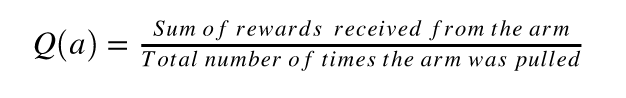

그에 따라 최대의 누적 보상을 주는 최적(optimal)의 레버는 아래와 같아진다.

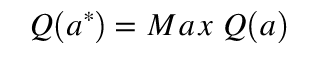

우리의 에이전트의 목적은 최적의 레버(ARM)을 찾는 것 뿐만 아니라 Regret을 최소화하는 것도 포함된다.    
regret은 정의된다. k개 Arm 중 최적의 Arm을 아는데 소요한 비용으로. 어떻게 최고의 Arm을 찾을까?    
모든 Arm들을 조사해야 할까? ( Exploration, GO 스톱)
지금까지 최대 누적 보상을 주는 Arm을 선택해야 할까? ( Exploitation, 고 STOP)

- 하나의 레버만 당기면 다른 레버를 모른다.
- 모든 레버를 도전해서 좋은 레버에서 얻을 수익을 못얻는다.

Exploration과 Exploitation의 TradeOff가 딜레마이다. ( 핵심 )   
다양한 Exploration 전략이 있는데 다음과 같다
- Epsilon-Greedy Policy ( 그리디 한데 입실론 확률로 반항 )
- Softmax Exploration ( Softmax 함수를 써서 Exploration )
- Upper Confidence Bound Problem ( 예측 범위, 예측 범위 신뢰도 )
- Thomson Sampling Technique ( 연속적 확률 분포, 샘플링)

우선 Gym 라이브러리를 설치한다. ( 코랩에서 쓰기가 쉽지 않네 )

In [0]:
!pip install gym > /dev/null 2>&1

In [0]:
!pip install gym-bandits > /dev/null 2>&1

In [0]:
import gym_bandits
import gym
import numpy as np
import math 
import random

Gym 라이브러리를 사용하는 목적   
강화 학습을 위한 표준화된 인풋과 아웃풋들을 공통 인터페이스에서 사용하기 위한    environment의 컬렉션을 제공하기 위해서다. 

In [25]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

강화학습 프레임워크는 아래와 같은 방향으로 동작한다.
1. Agent가 있다. ( 뇌와 같이 선택을 하는 머신러닝 알고리즘 )
2. Agent가 Action을 취한다.
3. Action이 선택되면 Environment에 먹인다.( Feed Action )
4. Environment는 Reward를 내보낸다. ( Get Rewards )
  - 높을 수록 좋은 보상이고 낮을 수록 나쁜 보상이다.
5. Environment는 Observation을 내보낸다, 업데이트된 Environment, State
6. 새로운 Observation과 Reward는 Agent로 다시 Feed-Back 된다.
7. 1번을 다시한다.

In [0]:
env = gym.make("MultiarmedBandits-v0") # 10-armed bandit
# env = gym.make('MultiArmedBandits-v0', nr_arms=15) # 15-armed bandit

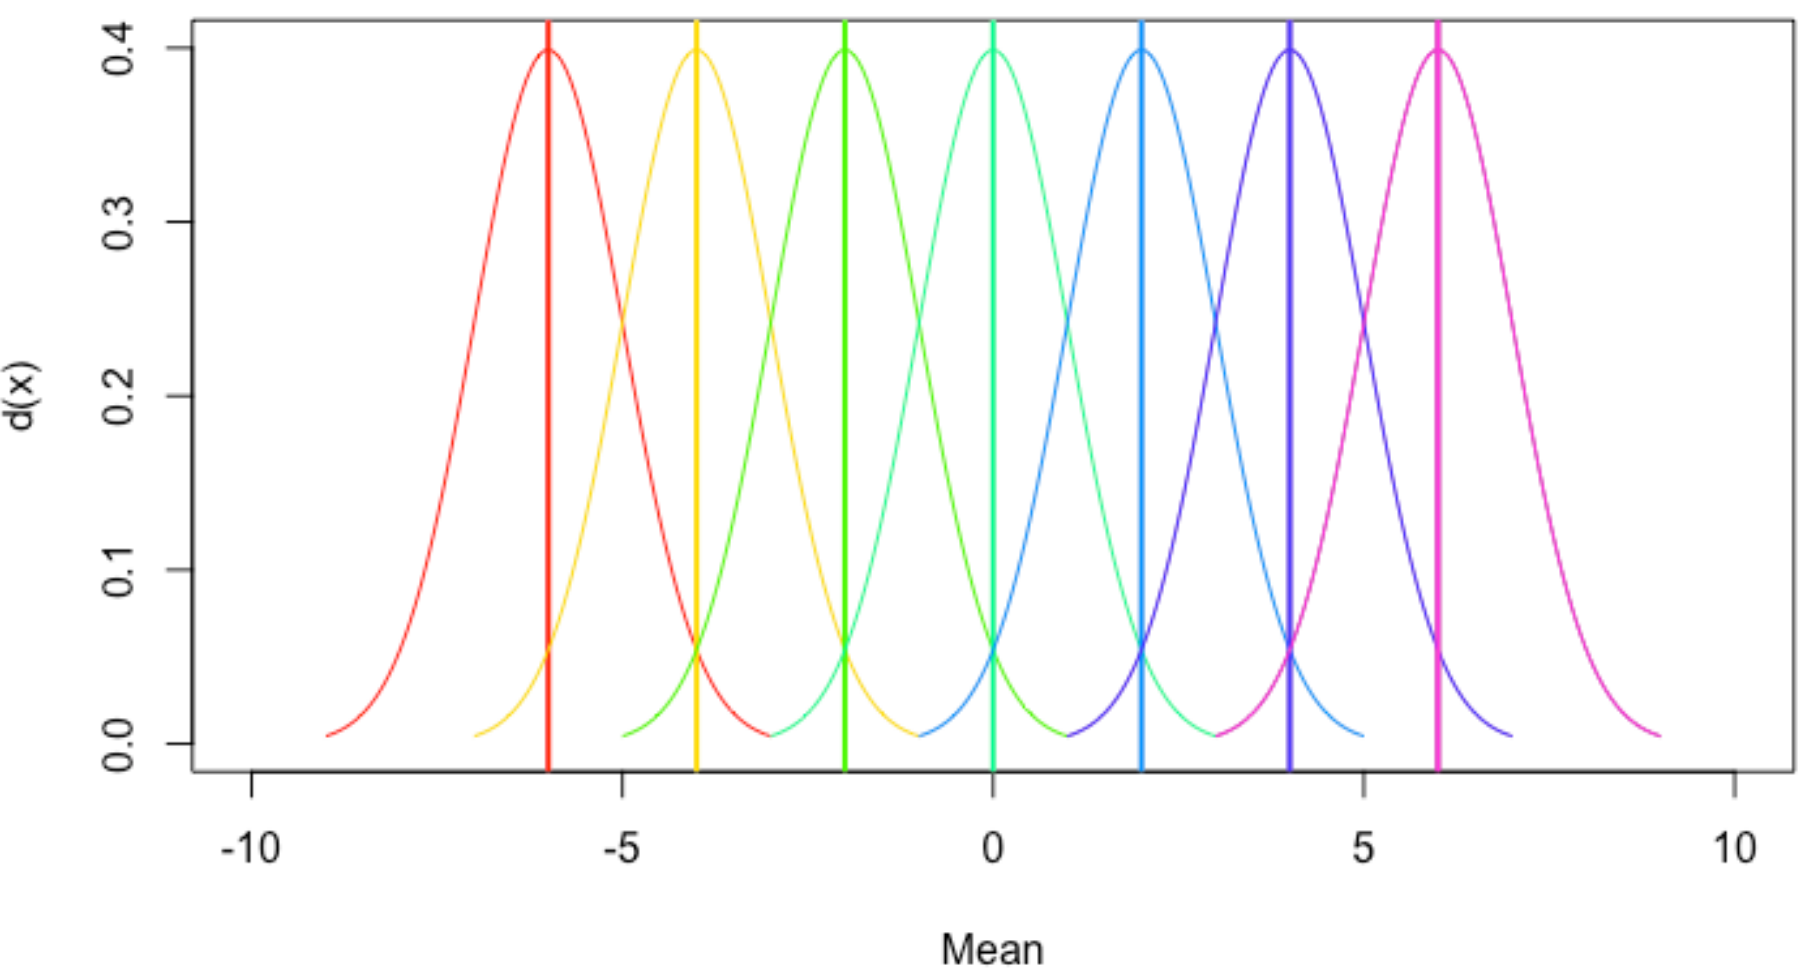

# Epsilon-Greedy Policy

In [0]:
def epsilon_greedy(epsilon=0.5):
  rand = np.random.random()
  if rand < epsilon:
    action = env.action_space.sample() # 10개의 레버를 당기는 액션 배열을 샘플링한다
  else:
    action = np.argmax(Q)
  return action

In [0]:
# 게임할 라운드 수 ( 총 반복 횟수 )
num_rounds = 20000

# ARM(레버)이 당겨진 횟수
count = np.zeros(10)

# 각 ARM에서 나온 보상의 합
sum_rewards = np.zeros(10)

# Q 값 -> 평균 보상
Q = np.zeros(10)

In [0]:
# 레버를 당겨보자!!!
for i in range(num_rounds):
  # 입실론 그리디 방법을 사용해서 Arm(레버)를 선택한다
  selected_arm = epsilon_greedy(0.5)
  
  # 선택한 Arm의 보상을 받는다. step을 environment에 적용한다.
  observation, reward, done, info = env.step(selected_arm)
  # 입실론 그리디 방법에서는 DONE과 INFO에 대해서는 몰라도 됨.
  # 본 코드에서는 REWARD와 OBSERVATION 변수들을 Agent에 피딩하지는 않는다.

  #print("observation space is: ",observation)
  #print("reward variable is: ",reward)
  #print("done flag is: ",done)
  #print("info variable is: ",info)
  
  # 각 ARM(레버)가 당겨진 횟수를 업데이트한다.
  count[arm] += 1

  # 각 ARM(레버)를 통해 얻어진 누적 보상을 업데이트한다.
  sum_rewards[arm] += reward
  
  # 각 ARM(레버)의 평균 보상인 Q값을 업데이트
  Q[arm] = sum_rewards[arm] / count[arm]
  

In [39]:
print(f"최적 ARM(레버)는 {np.argmax(Q)} 이다.")

최적 ARM(레버)는 4 이다.


#Softmax Exploration
Softmax(소프트맥스)는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수이다.    
tau 는 온도 파라미터다. 
- tau가 높아질수록, 모든 액션이 거의 같은 확률을 가지게 된다.
- tau가 낮아질수록, 액션 간의 격차가 크게 나게 된다.

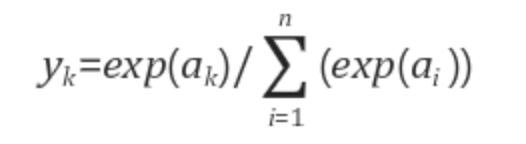

In [0]:
def softmax(tau):
  total = sum([math.exp(val/tau) for val in Q])
  probs = [math.exp(val/tau)/total for val in Q]

  threshold = random.random()
  cumulative_prob = 0.0

  for i in range(len(probs)):
    cumulative_prob += probs[i]
    if( cumulative_prob > threshold):
      return i
  return np.argmax(probs)

In [0]:
# 게임할 라운드 수 ( 총 반복 횟수 )
num_rounds = 20000

# ARM(레버)이 당겨진 횟수
count = np.zeros(10)

# 각 ARM에서 나온 보상의 합
sum_rewards = np.zeros(10)

# Q 값 -> 평균 보상
Q = np.zeros(10)

In [0]:
for i in range(num_rounds):
    
    # Select the arm using softmax
    arm = softmax(0.5)
    
    # Get the reward
    observation, reward, done, info = env.step(arm) 
    
    # update the count of that arm
    count[arm] += 1
    
    # Sum the rewards obtained from the arm
    sum_rewards[arm]+=reward
    
    # calculate Q value which is the average rewards of the arm
    Q[arm] = sum_rewards[arm]/count[arm]

In [50]:
print(f"최적 ARM(레버)는 {np.argmax(Q)} 이다.")

최적 ARM(레버)는 4 이다.


#Upper Confidence Bound

In [0]:
def UCB(iters):
    
    ucb = np.zeros(10)
    
    #explore all the arms
    if iters < 10:
        return i
    
    else:
        for arm in range(10):
            
            # calculate upper bound
            upper_bound = math.sqrt((2*math.log(sum(count))) / count[arm])
            
            # add upper bound to the Q valyue
            ucb[arm] = Q[arm] + upper_bound
            
        # return the arm which has maximum value
        return (np.argmax(ucb))

In [0]:
# 게임할 라운드 수 ( 총 반복 횟수 )
num_rounds = 20000

# ARM(레버)이 당겨진 횟수
count = np.zeros(10)

# 각 ARM에서 나온 보상의 합
sum_rewards = np.zeros(10)

# Q 값 -> 평균 보상
Q = np.zeros(10)

In [0]:
for i in range(num_rounds):
    
    # Select the arm using UCB
    arm = UCB(i)
    
    # Get the reward
    observation, reward, done, info = env.step(arm) 
    
    # update the count of that arm
    count[arm] += 1
    
    # Sum the rewards obtained from the arm
    sum_rewards[arm]+=reward
    
    # calculate Q value which is the average rewards of the arm
    Q[arm] = sum_rewards[arm]/count[arm]

In [56]:
print(f"최적 ARM(레버)는 {np.argmax(Q)} 이다.")

최적 ARM(레버)는 4 이다.


#Thompson Sampling

In [0]:
def thompson_sampling(alpha,beta):
    
    samples = [np.random.beta(alpha[i]+1,beta[i]+1) for i in range(10)]

    return np.argmax(samples)

In [0]:
# 게임할 라운드 수 ( 총 반복 횟수 )
num_rounds = 20000

# ARM(레버)이 당겨진 횟수
count = np.zeros(10)

# 각 ARM에서 나온 보상의 합
sum_rewards = np.zeros(10)

# Q 값 -> 평균 보상
Q = np.zeros(10)

# 알파와 베타 값들을 초기화한다
alpha = np.ones(10)
beta = np.ones(10)

In [0]:
for i in range(num_rounds):
    
    # Select the arm using thompson sampling
    arm = thompson_sampling(alpha,beta)
    
    # Get the reward
    observation, reward, done, info = env.step(arm) 
    
    # update the count of that arm
    count[arm] += 1
    
    # Sum the rewards obtained from the arm
    sum_rewards[arm]+=reward
    
    # calculate Q value which is the average rewards of the arm
    Q[arm] = sum_rewards[arm]/count[arm]

    # If it is a positive reward increment alpha
    if reward >0:
        alpha[arm] += 1
        
    # If it is a negative reward increment beta
    else:
        beta[arm] += 1

In [63]:
print(f"최적 ARM(레버)는 {np.argmax(Q)} 이다.")

최적 ARM(레버)는 4 이다.
